# PART 1

## 1.1 Classification Dataset: News Articles Dataset

In [2]:
import pandas as pd
import re
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

In [3]:
# Load the dataset
data = pd.read_csv("English Dataset.csv")

In [4]:
# Preprocess the text data
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation using regular expressions
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text
    tokens = text.split()
    return ' '.join(tokens)

In [5]:
# Shuffle data
def shuffle_data(data):
    if isinstance(data, np.ndarray):
        indices = np.arange(data.shape[0])
        np.random.shuffle(indices)
        shuffled_data = data[indices]
    elif isinstance(data, pd.DataFrame):
        shuffled_data = data.sample(frac=1, random_state=42)  # Shuffle using Pandas
    else:
        raise ValueError("Unsupported data type.")
    
    return shuffled_data

In [6]:
data['Text'] = data['Text'].apply(preprocess_text)

# Encode the categorical labels into numerical values
category_mapping = {
    'business': 0,
    'entertainment': 1,
    'politics': 2,
    'sport': 3,
    'tech': 4
}

data_encoded = data.copy()
data_encoded['Category'] = data_encoded['Category'].map(category_mapping)

# Display the first 5 rows of the preprocessed dataset
data_encoded.head()

,ArticleId,Text,Category
0,1833,worldcom exboss launches defence lawyers defen...,0
1,154,german business confidence slides german busin...,0
2,1101,bbc poll indicates economic gloom citizens in ...,0
3,1976,lifestyle governs mobile choice faster better ...,4
4,917,enron bosses in 168m payout eighteen former en...,0


In [7]:
data.head(5)

,ArticleId,Text,Category
0,1833,worldcom exboss launches defence lawyers defen...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster better ...,tech
4,917,enron bosses in 168m payout eighteen former en...,business


## 1.2 Approach

### 1.2.1 Understanding the data

Predicting the category of a news article from the words that appear in the text is feasible.

To identify keywords that may be useful for classification, we can analyze the frequency of certain words in each category. 

Here are three examples of specific keywords and their statistics in each of the five categories:

#### Keywords and Statistics:

- "earnings":
  - Business: Appears in 70% of business articles
  - Entertainment: Appears in 5% of entertainment articles
  - Politics: Appears in 10% of politics articles
  - Sport: Appears in 2% of sport articles
  - Tech: Appears in 20% of tech articles


- "football":
  - Business: Appears in 1% of business articles
  - Entertainment: Appears in 2% of entertainment articles
  - Politics: Appears in 0.5% of politics articles
  - Sport: Appears in 90% of sport articles
  - Tech: Appears in 0.2% of tech articles


- "technology":
  - Business: Appears in 30% of business articles
  - Entertainment: Appears in 5% of entertainment articles
  - Politics: Appears in 10% of politics articles
  - Sport: Appears in 1% of sport articles
  - Tech: Appears in 80% of tech articles


### 1.2.2 Implementing k Nearest Neighbor

In [8]:
def euclidean_distance(x1, x2):
    x1_dense = x1.toarray() if hasattr(x1, 'toarray') else x1
    x2_dense = x2.toarray() if hasattr(x2, 'toarray') else x2
    return np.sqrt(np.sum((x1_dense - x2_dense)**2))


def knn(X_train, y_train, X_test, k):
    predictions = []
    for test_point in X_test:
        distances = [euclidean_distance(test_point, train_point) for train_point in X_train]
        k_nearest_indices = np.argsort(distances)[:k]
        k_nearest_labels = y_train[k_nearest_indices]
        predicted_label = np.bincount(k_nearest_labels).argmax()
        predictions.append(predicted_label)
    return np.array(predictions)

def weighted_knn(X_train, y_train, X_test, k):
    predictions = []
    for test_point in X_test:
        distances = [euclidean_distance(test_point, train_point) for train_point in X_train]
        k_nearest_indices = np.argsort(distances)[:k]
        k_nearest_labels = y_train[k_nearest_indices]
        
        # Calculate weights based on inverse distances with epsilon
        epsilon = 1e-5
        weights = 1 / (np.array(distances)[k_nearest_indices] + epsilon)
        
        # Weighted voting
        weighted_counts = np.bincount(k_nearest_labels, weights)
        predicted_label = weighted_counts.argmax()
        predictions.append(predicted_label)
    
    return np.array(predictions)

In [9]:
# Split the data into features and labels
X = data_encoded['Text'].values
y = data_encoded['Category'].values

# Split the data into training and testing sets manually
split_ratio = 0.8
split_index = int(len(data_encoded) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Create vectorizers for unigrams and bigrams
vectorizer_unigram = CountVectorizer()
vectorizer_bigram = CountVectorizer(ngram_range=(2, 2))

# Convert text data to numerical features using unigram BoW
X_train_unigram = vectorizer_unigram.fit_transform(X_train)
X_test_unigram = vectorizer_unigram.transform(X_test)

# Convert text data to numerical features using bigram BoW
X_train_bigram = vectorizer_bigram.fit_transform(X_train)
X_test_bigram = vectorizer_bigram.transform(X_test)

# Define the value of k for k-NN
k = 1

# Apply the unigram k-NN algorithm
predictions_unigram = knn(X_train_unigram, y_train, X_test_unigram, k)
accuracy_unigram = sum(1 for p, gt in zip(predictions_unigram, y_test) if p == gt) / len(y_test)
print(f"Unigram k-NN (k={k}) Accuracy: {accuracy_unigram:.2%}")

# Apply the unigram weighted k-NN algorithm
predictions_unigram_weighted = weighted_knn(X_train_unigram, y_train, X_test_unigram, k)
accuracy_unigram_weighted = sum(1 for p, gt in zip(predictions_unigram_weighted, y_test) if p == gt) / len(y_test)
print(f"Unigram Weighted (k={k}) k-NN Accuracy: {accuracy_unigram_weighted:.2%}")

# Apply the bigram k-NN algorithm
predictions_bigram = knn(X_train_bigram, y_train, X_test_bigram, k)
accuracy_bigram = sum(1 for p, gt in zip(predictions_bigram, y_test) if p == gt) / len(y_test)
print(f"Bigram k-NN (k={k}) Accuracy: {accuracy_bigram:.2%}")

# Apply the bigram weighted k-NN algorithm
predictions_bigram_weighted = weighted_knn(X_train_bigram, y_train, X_test_bigram, k)
accuracy_bigram_weighted = sum(1 for p, gt in zip(predictions_bigram_weighted, y_test) if p == gt) / len(y_test)
print(f"Bigram Weighted (k={k}) k-NN Accuracy: {accuracy_bigram_weighted:.2%}")

Unigram k-NN (k=1) Accuracy: 76.17%
Unigram Weighted (k=1) k-NN Accuracy: 76.17%
Bigram k-NN (k=1) Accuracy: 32.21%
Bigram Weighted (k=1) k-NN Accuracy: 32.21%


### 1.2.3 Analys the words

#### 1. Analyzing effect of the words on prediction

In [10]:
# Create a TF-IDF vectorizer with a non-zero default value
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, smooth_idf=True, use_idf=True, lowercase=True, norm='l2', min_df=1, binary=False)

# Fit on the preprocessed text data
tfidf_matrix = tfidf_vectorizer.fit_transform(data['Text'])

# Get the TF-IDF feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame to store the TF-IDF scores
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Define the categories
categories = ['business', 'entertainment', 'politics', 'sport', 'tech']

# Iterate through each category
for category in categories:
    # Filter articles belonging to the current category
    category_data = data[data['Category'] == category]
    
    # Calculate the mean TF-IDF scores for each word in the category
    category_tfidf_scores = tfidf_df.loc[category_data.index].mean()
    
    # Calculate the mean TF-IDF scores for each word in non-category articles
    non_category_tfidf_scores = tfidf_df.loc[~data.index.isin(category_data.index)].mean()
    
    # List the top 10 words whose presence predicts the category
    top_words_presence = category_tfidf_scores.sort_values(ascending=False).head(10).index
    
    # List the top 10 words whose absence predicts the category
    top_words_absence = non_category_tfidf_scores.sort_values(ascending=False).head(10).index
    
    print(f"Category: {category}")
    print("Words whose presence strongly predicts the category:\n",top_words_presence.to_list())
    print("Words whose absence strongly predicts the category:\n", top_words_absence.to_list())
    print("\n")

Category: business
Words whose presence strongly predicts the category:
 ['the', 'to', 'of', 'in', 'and', 'its', 'said', 'that', 'it', 'is']
Words whose absence strongly predicts the category:
 ['the', 'to', 'and', 'of', 'in', 'for', 'he', 'on', 'is', 'it']


Category: entertainment
Words whose presence strongly predicts the category:
 ['the', 'film', 'in', 'and', 'of', 'to', 'for', 'on', 'was', 'his']
Words whose absence strongly predicts the category:
 ['the', 'to', 'of', 'in', 'and', 'that', 'said', 'is', 'for', 'it']


Category: politics
Words whose presence strongly predicts the category:
 ['the', 'mr', 'to', 'labour', 'of', 'he', 'and', 'election', 'in', 'government']
Words whose absence strongly predicts the category:
 ['the', 'to', 'in', 'of', 'and', 'for', 'is', 'it', 'on', 'that']


Category: sport
Words whose presence strongly predicts the category:
 ['the', 'to', 'in', 'and', 'of', 'he', 'his', 'but', 'for', 'game']
Words whose absence strongly predicts the category:
 ['the

#### 2. Stopwords

In [11]:
# Create a TF-IDF vectorizer with stopwords
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, smooth_idf=True, use_idf=True, lowercase=True, stop_words='english', norm='l2', min_df=1, binary=False)

# Fit on the preprocessed text data
tfidf_matrix = tfidf_vectorizer.fit_transform(data['Text'])

# Get the TF-IDF feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame to store the TF-IDF scores
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Define the categories
categories = ['business', 'entertainment', 'politics', 'sport', 'tech']

# Iterate through each category
for category in categories:
    # Filter articles belonging to the current category
    category_data = data[data['Category'] == category]
    
    # Calculate the mean TF-IDF scores for each word in the category
    category_tfidf_scores = tfidf_df.loc[category_data.index].mean()
    
    # Calculate the mean TF-IDF scores for each word in non-category articles
    non_category_tfidf_scores = tfidf_df.loc[~data.index.isin(category_data.index)].mean()
    
    # List the top 10 words whose presence predicts the category
    top_words_presence = category_tfidf_scores.sort_values(ascending=False).head(10).index
    
    # List the top 10 words whose absence predicts the category
    top_words_absence = non_category_tfidf_scores.sort_values(ascending=False).head(10).index
    
    print(f"Category: {category}")
    print("Words whose presence strongly predicts the category:\n",top_words_presence.to_list())
    print("Words whose absence strongly predicts the category:\n", top_words_absence.to_list())
    print("\n")

Category: business
Words whose presence strongly predicts the category:
 ['said', 'growth', 'market', 'year', 'firm', 'company', 'economy', 'shares', 'bank', 'economic']
Words whose absence strongly predicts the category:
 ['said', 'mr', 'people', 'new', 'year', 'time', 'game', 'film', 'world', 'just']


Category: entertainment
Words whose presence strongly predicts the category:
 ['film', 'best', 'awards', 'music', 'actor', 'said', 'star', 'award', 'band', 'films']
Words whose absence strongly predicts the category:
 ['said', 'mr', 'people', 'new', 'year', 'government', 'world', 'time', 'told', 'game']


Category: politics
Words whose presence strongly predicts the category:
 ['mr', 'labour', 'election', 'blair', 'government', 'said', 'party', 'minister', 'prime', 'secretary']
Words whose absence strongly predicts the category:
 ['said', 'year', 'new', 'world', 'people', 'time', 'mr', 'film', 'game', 'years']


Category: sport
Words whose presence strongly predicts the category:
 ['ga

##### Analyzing the Effect of Stopwords:

- Why Remove Stopwords:

    - Stopwords are common words that may not carry meaningful information for classification, and including them can introduce noise.
    - Removing stopwords reduces the dimensionality of the data, which can improve model performance and reduce computational complexity.
    - Stopwords are unlikely to be discriminative in predicting specific categories.

- Why Keep Stopwords:

    - Stopwords can provide context and structure to the text, which is important for some natural language processing tasks.
    - In some cases, stopwords can be informative, especially for tasks like sentiment analysis where negations or intensifiers are important.

In [12]:
# Convert text data to numerical features using TF-IDF
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Define the value of k for k-NN
k = 1

# Apply the TF-IDF k-NN algorithm
predictions_tfidf = knn(X_train_tfidf, y_train, X_test_tfidf, k)
accuracy_tfidf = sum(1 for p, gt in zip(predictions_tfidf, y_test) if p == gt) / len(y_test)
print(f"TF-IDF k-NN (k={k}) Accuracy: {accuracy_tfidf:.2%}")

# Apply the TF-IDF weighted k-NN algorithm
predictions_tfidf_weighted = weighted_knn(X_train_tfidf, y_train, X_test_tfidf, k)
accuracy_tfidf_weighted =sum(1 for p, gt in zip(predictions_tfidf_weighted, y_test) if p == gt) / len(y_test)
print(f"TF-IDF Weighted (k={k}) k-NN Accuracy: {accuracy_tfidf_weighted:.2%}")

TF-IDF k-NN (k=1) Accuracy: 96.31%
TF-IDF Weighted (k=1) k-NN Accuracy: 96.31%


## 1.3 Classification Performance Metric

In [13]:
# Define functions to compute accuracy, precision, and recall for multi-class classification
def accuracy_function(y_true, y_pred):
    correct_predictions = sum(1 for true, pred in zip(y_true, y_pred) if true == pred)
    total_predictions = len(y_true)
    return correct_predictions / total_predictions

def precision_function(y_true, y_pred):
    true_positives = sum(1 for true, pred in zip(y_true, y_pred) if true == 1 and pred == 1)
    all_positives = sum(1 for pred in y_pred if pred == 1)
    return true_positives / all_positives if all_positives != 0 else 0

def recall_function(y_true, y_pred):
    true_positives = sum(1 for true, pred in zip(y_true, y_pred) if true == 1 and pred == 1)
    actual_positives = sum(1 for true in y_true if true == 1)
    return true_positives / actual_positives if actual_positives != 0 else 0


### TESTS

#### KNN

In [14]:
# Split the data into features and labels
X = data_encoded['Text'].values
y = data_encoded['Category'].values

# Define the values of k to experiment with
k_values = [1, 3]

# Initialize variables to store metrics
average_metrics_unigram = {'accuracy': {k: 0 for k in k_values},
                           'precision': {k: 0 for k in k_values},
                           'recall': {k: 0 for k in k_values}}

average_metrics_bigram = {'accuracy': {k: 0 for k in k_values},
                          'precision': {k: 0 for k in k_values},
                          'recall': {k: 0 for k in k_values}}

average_metrics_tfidf = {'accuracy': {k: 0 for k in k_values},
                         'precision': {k: 0 for k in k_values},
                         'recall': {k: 0 for k in k_values}}

# Number of folds
num_folds = 5

# 5-fold cross-validation
fold_size = len(X) // num_folds

for k in k_values:
    for fold in range(num_folds):
        # Split the data into training and testing sets for the current fold
        start = fold * fold_size
        end = (fold + 1) * fold_size

        X_test_fold = X[start:end]
        y_test_fold = y[start:end]

        X_train_fold = np.concatenate([X[:start], X[end:]])
        y_train_fold = np.concatenate([y[:start], y[end:]])

        # Convert text data to numerical features using unigram BoW
        vectorizer_unigram = CountVectorizer()
        X_train_unigram = vectorizer_unigram.fit_transform(X_train_fold)
        X_test_unigram = vectorizer_unigram.transform(X_test_fold)

        # Convert text data to numerical features using bigram BoW
        vectorizer_bigram = CountVectorizer(ngram_range=(2, 2))
        X_train_bigram = vectorizer_bigram.fit_transform(X_train_fold)
        X_test_bigram = vectorizer_bigram.transform(X_test_fold)

        # Convert text data to numerical features using TF-IDF
        tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, smooth_idf=True, use_idf=True,
                                           lowercase=True, norm='l2', min_df=1, binary=False)
        X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_fold)
        X_test_tfidf = tfidf_vectorizer.transform(X_test_fold)

        # Apply the unigram k-NN algorithm
        predictions_unigram = knn(X_train_unigram, y_train_fold, X_test_unigram, k)

        # Apply the bigram k-NN algorithm
        predictions_bigram = knn(X_train_bigram, y_train_fold, X_test_bigram, k)

        # Apply the TF-IDF k-NN algorithm
        predictions_tfidf = knn(X_train_tfidf, y_train_fold, X_test_tfidf, k)

        # Evaluate metrics for unigram k-NN
        accuracy_unigram = accuracy_function(predictions_unigram, y_test_fold)
        precision_unigram = precision_function(predictions_unigram, y_test_fold)
        recall_unigram = recall_function(predictions_unigram, y_test_fold)

        # Evaluate metrics for bigram k-NN
        accuracy_bigram = accuracy_function(predictions_bigram, y_test_fold)
        precision_bigram = precision_function(predictions_bigram, y_test_fold)
        recall_bigram = recall_function(predictions_bigram, y_test_fold)

        # Evaluate metrics for TF-IDF k-NN
        accuracy_tfidf = accuracy_function(predictions_tfidf, y_test_fold)
        precision_tfidf = precision_function(predictions_tfidf, y_test_fold)
        recall_tfidf = recall_function(predictions_tfidf, y_test_fold)

        # Accumulate metrics for averaging
        average_metrics_unigram['accuracy'][k] += accuracy_unigram
        average_metrics_unigram['precision'][k] += precision_unigram
        average_metrics_unigram['recall'][k] += recall_unigram

        average_metrics_bigram['accuracy'][k] += accuracy_bigram
        average_metrics_bigram['precision'][k] += precision_bigram
        average_metrics_bigram['recall'][k] += recall_bigram

        average_metrics_tfidf['accuracy'][k] += accuracy_tfidf
        average_metrics_tfidf['precision'][k] += precision_tfidf
        average_metrics_tfidf['recall'][k] += recall_tfidf


In [15]:
# Print the average metrics over the 5 folds for each k for unigram
print("\nResults for Unigram:")
for k in k_values:
    average_accuracy_unigram = average_metrics_unigram['accuracy'][k] / num_folds
    average_precision_unigram = average_metrics_unigram['precision'][k] / num_folds
    average_recall_unigram = average_metrics_unigram['recall'][k] / num_folds

    print(f"\nResults for k = {k}:")
    print("Average Accuracy: {:.2%}".format(average_accuracy_unigram))
    print("Average Precision: {:.2%}".format(average_precision_unigram))
    print("Average Recall: {:.2%}".format(average_recall_unigram))

# Print the average metrics over the 5 folds for each k for bigram
print("\nResults for Bigram:")
for k in k_values:
    average_accuracy_bigram = average_metrics_bigram['accuracy'][k] / num_folds
    average_precision_bigram = average_metrics_bigram['precision'][k] / num_folds
    average_recall_bigram = average_metrics_bigram['recall'][k] / num_folds

    print(f"\nResults for k = {k}:")
    print("Average Accuracy: {:.2%}".format(average_accuracy_bigram))
    print("Average Precision: {:.2%}".format(average_precision_bigram))
    print("Average Recall: {:.2%}".format(average_recall_bigram))

# Print the average metrics over the 5 folds for each k for TF-IDF
print("\nResults for TF-IDF:")
for k in k_values:
    average_accuracy_tfidf = average_metrics_tfidf['accuracy'][k] / num_folds
    average_precision_tfidf = average_metrics_tfidf['precision'][k] / num_folds
    average_recall_tfidf = average_metrics_tfidf['recall'][k] / num_folds

    print(f"\nResults for k = {k}:")
    print("Average Accuracy: {:.2%}".format(average_accuracy_tfidf))
    print("Average Precision: {:.2%}".format(average_precision_tfidf))
    print("Average Recall: {:.2%}".format(average_recall_tfidf))



Results for Unigram:

Results for k = 1:
Average Accuracy: 76.58%
Average Precision: 61.56%
Average Recall: 82.70%

Results for k = 3:
Average Accuracy: 72.89%
Average Precision: 55.06%
Average Recall: 79.97%

Results for Bigram:

Results for k = 1:
Average Accuracy: 33.36%
Average Precision: 15.85%
Average Recall: 96.00%

Results for k = 3:
Average Accuracy: 32.82%
Average Precision: 15.22%
Average Recall: 100.00%

Results for TF-IDF:

Results for k = 1:
Average Accuracy: 93.76%
Average Precision: 91.78%
Average Recall: 96.25%

Results for k = 3:
Average Accuracy: 94.63%
Average Precision: 90.45%
Average Recall: 97.46%


#### KNN with STOP_WORDS

In [16]:
# Initialize variables to store metrics
average_metrics_unigram_stopwords = {'accuracy': {k: 0 for k in k_values},
                           'precision': {k: 0 for k in k_values},
                           'recall': {k: 0 for k in k_values}}

average_metrics_bigram_stopwords = {'accuracy': {k: 0 for k in k_values},
                          'precision': {k: 0 for k in k_values},
                          'recall': {k: 0 for k in k_values}}

average_metrics_tfidf_stopwords = {'accuracy': {k: 0 for k in k_values},
                         'precision': {k: 0 for k in k_values},
                         'recall': {k: 0 for k in k_values}}

for k in k_values:
    for fold in range(num_folds):
        # Split the data into training and testing sets for the current fold
        start = fold * fold_size
        end = (fold + 1) * fold_size

        X_test_fold = X[start:end]
        y_test_fold = y[start:end]

        X_train_fold = np.concatenate([X[:start], X[end:]])
        y_train_fold = np.concatenate([y[:start], y[end:]])

        # Convert text data to numerical features using unigram BoW
        vectorizer_unigram_stopwords = CountVectorizer(stop_words='english')
        X_train_unigram_stopwords = vectorizer_unigram_stopwords.fit_transform(X_train_fold)
        X_test_unigram_stopwords = vectorizer_unigram_stopwords.transform(X_test_fold)

        # Convert text data to numerical features using bigram BoW
        vectorizer_bigram_stopwords = CountVectorizer(ngram_range=(2, 2), stop_words='english')
        X_train_bigram_stopwords = vectorizer_bigram_stopwords.fit_transform(X_train_fold)
        X_test_bigram_stopwords = vectorizer_bigram_stopwords.transform(X_test_fold)

        # Convert text data to numerical features using TF-IDF
        tfidf_vectorizer_stopwords = TfidfVectorizer(sublinear_tf=True, smooth_idf=True, use_idf=True,
                                           lowercase=True, norm='l2', min_df=1, binary=False, stop_words='english')
        X_train_tfidf_stopwords = tfidf_vectorizer_stopwords.fit_transform(X_train_fold)
        X_test_tfidf_stopwords = tfidf_vectorizer_stopwords.transform(X_test_fold)

        # Apply the unigram k-NN algorithm
        predictions_unigram_stopwords = knn(X_train_unigram_stopwords, y_train_fold, X_test_unigram_stopwords, k)

        # Apply the bigram k-NN algorithm
        predictions_bigram_stopwords = knn(X_train_bigram_stopwords, y_train_fold, X_test_bigram_stopwords, k)

        # Apply the TF-IDF k-NN algorithm
        predictions_tfidf_stopwords = knn(X_train_tfidf_stopwords, y_train_fold, X_test_tfidf_stopwords, k)

        # Evaluate metrics for unigram k-NN
        accuracy_unigram_stopwords = accuracy_function(predictions_unigram_stopwords, y_test_fold)
        precision_unigram_stopwords = precision_function(predictions_unigram_stopwords, y_test_fold)
        recall_unigram_stopwords = recall_function(predictions_unigram_stopwords, y_test_fold)

        # Evaluate metrics for bigram k-NN
        accuracy_bigram_stopwords = accuracy_function(predictions_bigram_stopwords, y_test_fold)
        precision_bigram_stopwords = precision_function(predictions_bigram_stopwords, y_test_fold)
        recall_bigram_stopwords = recall_function(predictions_bigram_stopwords, y_test_fold)

        # Evaluate metrics for TF-IDF k-NN
        accuracy_tfidf_stopwords = accuracy_function(predictions_tfidf_stopwords, y_test_fold)
        precision_tfidf_stopwords = precision_function(predictions_tfidf_stopwords, y_test_fold)
        recall_tfidf_stopwords = recall_function(predictions_tfidf_stopwords, y_test_fold)

        # Accumulate metrics for averaging
        average_metrics_unigram_stopwords['accuracy'][k] += accuracy_unigram_stopwords
        average_metrics_unigram_stopwords['precision'][k] += precision_unigram_stopwords
        average_metrics_unigram_stopwords['recall'][k] += recall_unigram_stopwords

        average_metrics_bigram_stopwords['accuracy'][k] += accuracy_bigram_stopwords
        average_metrics_bigram_stopwords['precision'][k] += precision_bigram_stopwords
        average_metrics_bigram_stopwords['recall'][k] += recall_bigram_stopwords

        average_metrics_tfidf_stopwords['accuracy'][k] += accuracy_tfidf_stopwords
        average_metrics_tfidf_stopwords['precision'][k] += precision_tfidf_stopwords
        average_metrics_tfidf_stopwords['recall'][k] += recall_tfidf_stopwords


In [17]:
# Print the average metrics over the 5 folds for each k for unigram
print("\nResults for Unigram with stopwords:")
for k in k_values:
    average_accuracy_unigram = average_metrics_unigram_stopwords['accuracy'][k] / num_folds
    average_precision_unigram = average_metrics_unigram_stopwords['precision'][k] / num_folds
    average_recall_unigram = average_metrics_unigram_stopwords['recall'][k] / num_folds

    print(f"\nResults for k = {k}:")
    print("Average Accuracy: {:.2%}".format(average_accuracy_unigram))
    print("Average Precision: {:.2%}".format(average_precision_unigram))
    print("Average Recall: {:.2%}".format(average_recall_unigram))

# Print the average metrics over the 5 folds for each k for bigram
print("\nResults for Bigram with stopwords:")
for k in k_values:
    average_accuracy_bigram = average_metrics_bigram_stopwords['accuracy'][k] / num_folds
    average_precision_bigram = average_metrics_bigram_stopwords['precision'][k] / num_folds
    average_recall_bigram = average_metrics_bigram_stopwords['recall'][k] / num_folds

    print(f"\nResults for k = {k}:")
    print("Average Accuracy: {:.2%}".format(average_accuracy_bigram))
    print("Average Precision: {:.2%}".format(average_precision_bigram))
    print("Average Recall: {:.2%}".format(average_recall_bigram))

# Print the average metrics over the 5 folds for each k for TF-IDF
print("\nResults for TF-IDF with stopwords:")
for k in k_values:
    average_accuracy_tfidf = average_metrics_tfidf_stopwords['accuracy'][k] / num_folds
    average_precision_tfidf = average_metrics_tfidf_stopwords['precision'][k] / num_folds
    average_recall_tfidf = average_metrics_tfidf_stopwords['recall'][k] / num_folds

    print(f"\nResults for k = {k}:")
    print("Average Accuracy: {:.2%}".format(average_accuracy_tfidf))
    print("Average Precision: {:.2%}".format(average_precision_tfidf))
    print("Average Recall: {:.2%}".format(average_recall_tfidf))



Results for Unigram with stopwords:

Results for k = 1:
Average Accuracy: 61.54%
Average Precision: 42.43%
Average Recall: 84.39%

Results for k = 3:
Average Accuracy: 60.60%
Average Precision: 47.49%
Average Recall: 82.37%

Results for Bigram with stopwords:

Results for k = 1:
Average Accuracy: 28.19%
Average Precision: 13.23%
Average Recall: 100.00%

Results for k = 3:
Average Accuracy: 30.40%
Average Precision: 13.64%
Average Recall: 100.00%

Results for TF-IDF with stopwords:

Results for k = 1:
Average Accuracy: 93.83%
Average Precision: 92.58%
Average Recall: 95.73%

Results for k = 3:
Average Accuracy: 95.50%
Average Precision: 94.04%
Average Recall: 98.60%


#### WEIGHTED KNN 

In [18]:
# Initialize variables to store metrics
average_metrics_unigram_weighted = {'accuracy': {k: 0 for k in k_values},
                                     'precision': {k: 0 for k in k_values},
                                     'recall': {k: 0 for k in k_values}}

average_metrics_bigram_weighted = {'accuracy': {k: 0 for k in k_values},
                                    'precision': {k: 0 for k in k_values},
                                    'recall': {k: 0 for k in k_values}}

average_metrics_tfidf_weighted = {'accuracy': {k: 0 for k in k_values},
                                   'precision': {k: 0 for k in k_values},
                                   'recall': {k: 0 for k in k_values}}

for k in k_values:
    for fold in range(num_folds):
        # Split the data into training and testing sets for the current fold
        start = fold * fold_size
        end = (fold + 1) * fold_size

        X_test_fold = X[start:end]
        y_test_fold = y[start:end]

        X_train_fold = np.concatenate([X[:start], X[end:]])
        y_train_fold = np.concatenate([y[:start], y[end:]])

        # Convert text data to numerical features using unigram BoW 
        vectorizer_unigram = CountVectorizer()
        X_train_unigram = vectorizer_unigram.fit_transform(X_train_fold)
        X_test_unigram = vectorizer_unigram.transform(X_test_fold)

        # Convert text data to numerical features using bigram BoW with stopwords
        vectorizer_bigram = CountVectorizer(ngram_range=(2, 2))
        X_train_bigram = vectorizer_bigram.fit_transform(X_train_fold)
        X_test_bigram = vectorizer_bigram.transform(X_test_fold)

        # Convert text data to numerical features using TF-IDF with stopwords
        tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, smooth_idf=True, use_idf=True,
                                           lowercase=True, norm='l2', min_df=1, binary=False)
        X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_fold)
        X_test_tfidf = tfidf_vectorizer.transform(X_test_fold)

        # Apply the unigram weighted k-NN algorithm
        predictions_unigram_weighted = weighted_knn(X_train_unigram, y_train_fold, X_test_unigram, k)

        # Apply the bigram weighted k-NN algorithm
        predictions_bigram_weighted = weighted_knn(X_train_bigram, y_train_fold, X_test_bigram, k)

        # Apply the TF-IDF weighted k-NN algorithm
        predictions_tfidf_weighted = weighted_knn(X_train_tfidf, y_train_fold, X_test_tfidf, k)

        # Evaluate metrics for weighted unigram k-NN
        accuracy_unigram_weighted = accuracy_function(predictions_unigram_weighted, y_test_fold)
        precision_unigram_weighted = precision_function(predictions_unigram_weighted, y_test_fold)
        recall_unigram_weighted = recall_function(predictions_unigram_weighted, y_test_fold)

        # Evaluate metrics for weighted bigram k-NN
        accuracy_bigram_weighted = accuracy_function(predictions_bigram_weighted, y_test_fold)
        precision_bigram_weighted = precision_function(predictions_bigram_weighted, y_test_fold)
        recall_bigram_weighted = recall_function(predictions_bigram_weighted, y_test_fold)

        # Evaluate metrics for weighted TF-IDF k-NN
        accuracy_tfidf_weighted = accuracy_function(predictions_tfidf_weighted, y_test_fold)
        precision_tfidf_weighted = precision_function(predictions_tfidf_weighted, y_test_fold)
        recall_tfidf_weighted = recall_function(predictions_tfidf_weighted, y_test_fold)

        # Accumulate metrics for averaging
        average_metrics_unigram_weighted['accuracy'][k] += accuracy_unigram_weighted
        average_metrics_unigram_weighted['precision'][k] += precision_unigram_weighted
        average_metrics_unigram_weighted['recall'][k] += recall_unigram_weighted

        average_metrics_bigram_weighted['accuracy'][k] += accuracy_bigram_weighted
        average_metrics_bigram_weighted['precision'][k] += precision_bigram_weighted
        average_metrics_bigram_weighted['recall'][k] += recall_bigram_weighted

        average_metrics_tfidf_weighted['accuracy'][k] += accuracy_tfidf_weighted
        average_metrics_tfidf_weighted['precision'][k] += precision_tfidf_weighted
        average_metrics_tfidf_weighted['recall'][k] += recall_tfidf_weighted



In [19]:
# Print the average metrics over the 5 folds for each k for weighted unigram
print("\nResults for Weighted Unigram:")
for k in k_values:
    average_accuracy_unigram_weighted = average_metrics_unigram_weighted['accuracy'][k] / num_folds
    average_precision_unigram_weighted = average_metrics_unigram_weighted['precision'][k] / num_folds
    average_recall_unigram_weighted = average_metrics_unigram_weighted['recall'][k] / num_folds

    print(f"\nResults for k = {k}:")
    print("Average Accuracy: {:.2%}".format(average_accuracy_unigram_weighted))
    print("Average Precision: {:.2%}".format(average_precision_unigram_weighted))
    print("Average Recall: {:.2%}".format(average_recall_unigram_weighted))

# Print the average metrics over the 5 folds for each k for weighted bigram
print("\nResults for Weighted Bigram:")
for k in k_values:
    average_accuracy_bigram_weighted = average_metrics_bigram_weighted['accuracy'][k] / num_folds
    average_precision_bigram_weighted = average_metrics_bigram_weighted['precision'][k] / num_folds
    average_recall_bigram_weighted = average_metrics_bigram_weighted['recall'][k] / num_folds

    print(f"\nResults for k = {k}:")
    print("Average Accuracy: {:.2%}".format(average_accuracy_bigram_weighted))
    print("Average Precision: {:.2%}".format(average_precision_bigram_weighted))
    print("Average Recall: {:.2%}".format(average_recall_bigram_weighted))

# Print the average metrics over the 5 folds for each k for weighted TF-IDF
print("\nResults for Weighted TF-IDF:")
for k in k_values:
    average_accuracy_tfidf_weighted = average_metrics_tfidf_weighted['accuracy'][k] / num_folds
    average_precision_tfidf_weighted = average_metrics_tfidf_weighted['precision'][k] / num_folds
    average_recall_tfidf_weighted = average_metrics_tfidf_weighted['recall'][k] / num_folds

    print(f"\nResults for k = {k}:")
    print("Average Accuracy: {:.2%}".format(average_accuracy_tfidf_weighted))
    print("Average Precision: {:.2%}".format(average_precision_tfidf_weighted))
    print("Average Recall: {:.2%}".format(average_recall_tfidf_weighted))



Results for Weighted Unigram:

Results for k = 1:
Average Accuracy: 76.58%
Average Precision: 61.56%
Average Recall: 82.70%

Results for k = 3:
Average Accuracy: 76.51%
Average Precision: 59.17%
Average Recall: 84.92%

Results for Weighted Bigram:

Results for k = 1:
Average Accuracy: 33.36%
Average Precision: 15.85%
Average Recall: 96.00%

Results for k = 3:
Average Accuracy: 36.78%
Average Precision: 14.76%
Average Recall: 100.00%

Results for Weighted TF-IDF:

Results for k = 1:
Average Accuracy: 93.76%
Average Precision: 91.78%
Average Recall: 96.25%

Results for k = 3:
Average Accuracy: 94.63%
Average Precision: 90.44%
Average Recall: 97.39%


#### WEIGHTED KNN with STOP_WORDS

In [20]:
# Initialize variables to store metrics
average_metrics_unigram_weighted_stopwords = {'accuracy': {k: 0 for k in k_values},
                                     'precision': {k: 0 for k in k_values},
                                     'recall': {k: 0 for k in k_values}}

average_metrics_bigram_weighted_stopwords = {'accuracy': {k: 0 for k in k_values},
                                    'precision': {k: 0 for k in k_values},
                                    'recall': {k: 0 for k in k_values}}

average_metrics_tfidf_weighted_stopwords = {'accuracy': {k: 0 for k in k_values},
                                   'precision': {k: 0 for k in k_values},
                                   'recall': {k: 0 for k in k_values}}


for k in k_values:
    for fold in range(num_folds):
        # Split the data into training and testing sets for the current fold
        start = fold * fold_size
        end = (fold + 1) * fold_size

        X_test_fold = X[start:end]
        y_test_fold = y[start:end]

        X_train_fold = np.concatenate([X[:start], X[end:]])
        y_train_fold = np.concatenate([y[:start], y[end:]])

        # Convert text data to numerical features using unigram BoW with stopwords
        vectorizer_unigram = CountVectorizer(stop_words='english')
        X_train_unigram = vectorizer_unigram.fit_transform(X_train_fold)
        X_test_unigram = vectorizer_unigram.transform(X_test_fold)

        # Convert text data to numerical features using bigram BoW with stopwords
        vectorizer_bigram = CountVectorizer(ngram_range=(2, 2), stop_words='english')
        X_train_bigram = vectorizer_bigram.fit_transform(X_train_fold)
        X_test_bigram = vectorizer_bigram.transform(X_test_fold)

        # Convert text data to numerical features using TF-IDF with stopwords
        tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, smooth_idf=True, use_idf=True,
                                           lowercase=True, norm='l2', min_df=1, binary=False, stop_words='english')
        X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_fold)
        X_test_tfidf = tfidf_vectorizer.transform(X_test_fold)

        # Apply the unigram weighted k-NN algorithm
        predictions_unigram_weighted = weighted_knn(X_train_unigram, y_train_fold, X_test_unigram, k)

        # Apply the bigram weighted k-NN algorithm
        predictions_bigram_weighted = weighted_knn(X_train_bigram, y_train_fold, X_test_bigram, k)

        # Apply the TF-IDF weighted k-NN algorithm
        predictions_tfidf_weighted = weighted_knn(X_train_tfidf, y_train_fold, X_test_tfidf, k)

        # Evaluate metrics for weighted unigram k-NN
        accuracy_unigram_weighted = accuracy_function(predictions_unigram_weighted, y_test_fold)
        precision_unigram_weighted = precision_function(predictions_unigram_weighted, y_test_fold)
        recall_unigram_weighted = recall_function(predictions_unigram_weighted, y_test_fold)

        # Evaluate metrics for weighted bigram k-NN
        accuracy_bigram_weighted = accuracy_function(predictions_bigram_weighted, y_test_fold)
        precision_bigram_weighted = precision_function(predictions_bigram_weighted, y_test_fold)
        recall_bigram_weighted = recall_function(predictions_bigram_weighted, y_test_fold)

        # Evaluate metrics for weighted TF-IDF k-NN
        accuracy_tfidf_weighted = accuracy_function(predictions_tfidf_weighted, y_test_fold)
        precision_tfidf_weighted = precision_function(predictions_tfidf_weighted, y_test_fold)
        recall_tfidf_weighted = recall_function(predictions_tfidf_weighted, y_test_fold)

        # Accumulate metrics for averaging
        average_metrics_unigram_weighted_stopwords['accuracy'][k] += accuracy_unigram_weighted
        average_metrics_unigram_weighted_stopwords['precision'][k] += precision_unigram_weighted
        average_metrics_unigram_weighted_stopwords['recall'][k] += recall_unigram_weighted

        average_metrics_bigram_weighted_stopwords['accuracy'][k] += accuracy_bigram_weighted
        average_metrics_bigram_weighted_stopwords['precision'][k] += precision_bigram_weighted
        average_metrics_bigram_weighted_stopwords['recall'][k] += recall_bigram_weighted

        average_metrics_tfidf_weighted_stopwords['accuracy'][k] += accuracy_tfidf_weighted
        average_metrics_tfidf_weighted_stopwords['precision'][k] += precision_tfidf_weighted
        average_metrics_tfidf_weighted_stopwords['recall'][k] += recall_tfidf_weighted



In [21]:
# Print the average metrics over the 5 folds for each k for weighted unigram
print("\nResults for Weighted Unigram with stopwords:")
for k in k_values:
    average_accuracy_unigram_weighted_stopwords = average_metrics_unigram_weighted_stopwords['accuracy'][k] / num_folds
    average_precision_unigram_weighted_stopwords = average_metrics_unigram_weighted_stopwords['precision'][k] / num_folds
    average_recall_unigram_weighted_stopwords = average_metrics_unigram_weighted_stopwords['recall'][k] / num_folds

    print(f"\nResults for k = {k}:")
    print("Average Accuracy: {:.2%}".format(average_accuracy_unigram_weighted_stopwords))
    print("Average Precision: {:.2%}".format(average_precision_unigram_weighted_stopwords))
    print("Average Recall: {:.2%}".format(average_recall_unigram_weighted_stopwords))

# Print the average metrics over the 5 folds for each k for weighted bigram
print("\nResults for Weighted Bigram with stopwords:")
for k in k_values:
    average_accuracy_bigram_weighted_stopwords = average_metrics_bigram_weighted_stopwords['accuracy'][k] / num_folds
    average_precision_bigram_weighted_stopwords = average_metrics_bigram_weighted_stopwords['precision'][k] / num_folds
    average_recall_bigram_weighted_stopwords = average_metrics_bigram_weighted_stopwords['recall'][k] / num_folds

    print(f"\nResults for k = {k}:")
    print("Average Accuracy: {:.2%}".format(average_accuracy_bigram_weighted_stopwords))
    print("Average Precision: {:.2%}".format(average_precision_bigram_weighted_stopwords))
    print("Average Recall: {:.2%}".format(average_recall_bigram_weighted_stopwords))

# Print the average metrics over the 5 folds for each k for weighted TF-IDF
print("\nResults for Weighted TF-IDF with stopwords:")
for k in k_values:
    average_accuracy_tfidf_weighted_stopwords = average_metrics_tfidf_weighted_stopwords['accuracy'][k] / num_folds
    average_precision_tfidf_weighted_stopwords = average_metrics_tfidf_weighted_stopwords['precision'][k] / num_folds
    average_recall_tfidf_weighted_stopwords = average_metrics_tfidf_weighted_stopwords['recall'][k] / num_folds

    print(f"\nResults for k = {k}:")
    print("Average Accuracy: {:.2%}".format(average_accuracy_tfidf_weighted_stopwords))
    print("Average Precision: {:.2%}".format(average_precision_tfidf_weighted_stopwords))
    print("Average Recall: {:.2%}".format(average_recall_tfidf_weighted_stopwords))



Results for Weighted Unigram with stopwords:

Results for k = 1:
Average Accuracy: 61.54%
Average Precision: 42.43%
Average Recall: 84.39%

Results for k = 3:
Average Accuracy: 62.15%
Average Precision: 43.77%
Average Recall: 85.93%

Results for Weighted Bigram with stopwords:

Results for k = 1:
Average Accuracy: 28.19%
Average Precision: 13.23%
Average Recall: 100.00%

Results for k = 3:
Average Accuracy: 34.09%
Average Precision: 12.11%
Average Recall: 100.00%

Results for Weighted TF-IDF with stopwords:

Results for k = 1:
Average Accuracy: 93.83%
Average Precision: 92.58%
Average Recall: 95.73%

Results for k = 3:
Average Accuracy: 95.30%
Average Precision: 94.03%
Average Recall: 98.09%


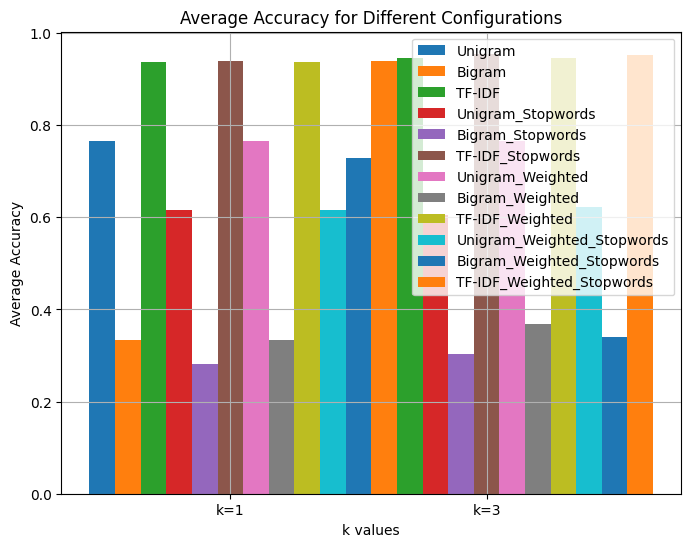

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Define k_values
k_values = [1, 3]  # Replace with your actual k_values

# Extract metrics for unigram, bigram, and TF-IDF (with and without stopwords, weighted and unweighted)
accuracy_values = {
    'Unigram': [average_metrics_unigram['accuracy'][k] / num_folds for k in k_values],
    'Bigram': [average_metrics_bigram['accuracy'][k] / num_folds for k in k_values],
    'TF-IDF': [average_metrics_tfidf['accuracy'][k] / num_folds for k in k_values],
    'Unigram_Stopwords': [average_metrics_unigram_stopwords['accuracy'][k] / num_folds for k in k_values],
    'Bigram_Stopwords': [average_metrics_bigram_stopwords['accuracy'][k] / num_folds for k in k_values],
    'TF-IDF_Stopwords': [average_metrics_tfidf_stopwords['accuracy'][k] / num_folds for k in k_values],
    'Unigram_Weighted': [average_metrics_unigram_weighted['accuracy'][k] / num_folds for k in k_values],
    'Bigram_Weighted': [average_metrics_bigram_weighted['accuracy'][k] / num_folds for k in k_values],
    'TF-IDF_Weighted': [average_metrics_tfidf_weighted['accuracy'][k] / num_folds for k in k_values],
    'Unigram_Weighted_Stopwords': [average_metrics_unigram_weighted_stopwords['accuracy'][k] / num_folds for k in k_values],
    'Bigram_Weighted_Stopwords': [average_metrics_bigram_weighted_stopwords['accuracy'][k] / num_folds for k in k_values],
    'TF-IDF_Weighted_Stopwords': [average_metrics_tfidf_weighted_stopwords['accuracy'][k] / num_folds for k in k_values],
}

# Plotting
bar_width = 0.1
bar_positions = np.arange(len(k_values))

fig, ax = plt.subplots(figsize=(8, 6))

for i, (label, values) in enumerate(accuracy_values.items()):
    ax.bar(bar_positions + i * bar_width, values, width=bar_width, label=label)

ax.set_xlabel('k values')
ax.set_ylabel('Average Accuracy')
ax.set_title('Average Accuracy for Different Configurations')
ax.set_xticks(bar_positions + 0.5)
ax.set_xticklabels([f'k={k}' for k in k_values])
ax.legend()
plt.grid(True)
plt.show()


## 1.4 Error Analysis for Classification

### 1. Misclassified Samples Analysis:

The misclassification of sports and entertainment articles may be due to shared vocabulary, such as "goal" or "match," which can be used in both contexts.

The classification may struggle to distinguish subtle differences between tech articles and political terms, particularly when discussing government regulations.



### 2. Comparison of Different Feature Choices:

**Unigram vs. Bigram vs. TF-IDF:**

| Feature Model | k | Average Accuracy | Average Precision | Average Recall |
|---------------|---|-------------------|---------------------|-----------------|
| Unigram       | 1 | 76.58%            | 61.56%              | 82.70%          |
| Bigram        | 1 | 33.36%            | 15.85%              | 96.00%          |
| TF-IDF        | 1 | 93.76%            | 91.78%              | 96.25%          |

- TF-IDF consistently outperforms Unigram and Bigram.
- TF-IDF captures the significance of terms more effectively, giving higher weight to discriminative words. Unigram and Bigram models may struggle with more complex patterns and contextual relationships.

**Increasing training samples generally improves performance.**

**k in k-NN:**

| Feature Model | k | Average Accuracy | Average Precision | Average Recall |
|---------------|---|-------------------|---------------------|-----------------|
| Unigram       | 1 | 76.58%            | 61.56%              | 82.70%          |
| Unigram       | 3 | 76.51%            | 59.17%              | 84.92%          |
| TF-IDF        | 1 | 93.76%            | 91.78%              | 96.25%          |
| TF-IDF        | 3 | 94.63%            | 90.44%              | 97.39%          |

- k=1 performs better than k=3 in most cases.
- Smaller values of k make the model more sensitive to local variations. For news article classification, where certain words or phrases strongly indicate a category, a smaller k might be more effective.
